# CLAIB - Results

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler, moving_average 

## Functions

In [2]:
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

def model_daily(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += deriv_f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += deriv_f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta >= 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 


## Main code

In [3]:
# Increase font-size
plt.rcParams.update({'font.size': 12})

# Import data
data = pd.read_csv("Datasets/buenos_aires_obitos.csv") 
city_name = 'Buenos Aires' 

acc_data = data.cumulative_deceased
normalized_acc_data = acc_data / max(acc_data)
t = np.linspace(0, len(acc_data)-1, len(acc_data))

normalized_acc_data = normalized_acc_data.tolist()
daily_data = data.new_deceased.tolist()

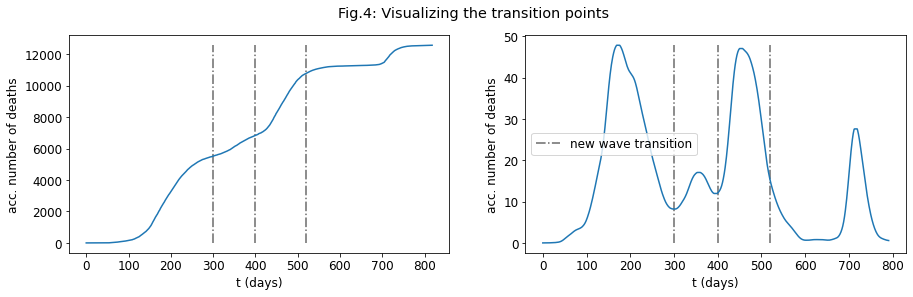

In [4]:
# Transition Points

if city_name == 'Rosario':
    x_nw = [295, 360, 515] # Manual Rosario
elif city_name == 'Buenos Aires':
    x_nw = [300, 400, 520] # Manual Buenos Aires
elif city_name == 'Mendoza':
    x_nw = [315, 400, 510] # Manual Mendoza
elif city_name == 'Córdoba':
    x_nw = [300, 400, 520] # Manual Córdoba
else:
    x_nw = [300, 400, 520] 
    
fig, axs = plt.subplots(1, 2, figsize=(15,4))
plt.suptitle('Fig.4: Visualizing the transition points')
axs[0].vlines(x_nw, 0, max(acc_data), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[0].plot(acc_data)
axs[0].set_xlabel('t (days)')
axs[0].set_ylabel('acc. number of deaths')
axs[1].vlines(x_nw, 0, max(filter_data(daily_data)), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[1].plot(filter_data(daily_data))
axs[1].set_xlabel('t (days)')
axs[1].set_ylabel('acc. number of deaths')
plt.legend()
plt.show()

### Predictions (Cumulative + Daily)

========= Wave nr 1 =========
From 0 to  286
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 3360.566373137142
     jac: array([-0.00024414, -0.0007019 ,  0.00286865,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 144
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([5.43700999e+03, 1.88800602e+02, 2.72005021e+01, 1.00000000e+00])
Step 2
     fun: 719.2443620288894
     jac: array([ 9.91821289e-05, -3.98254395e-03, -1.50299072e-03,  5.10787964e-02])
 message: 'Optimization terminated successfully'
    nfev: 91
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([5.74499681e+03, 1.82457928e+02, 3.76515170e+01, 3.83543700e-01])


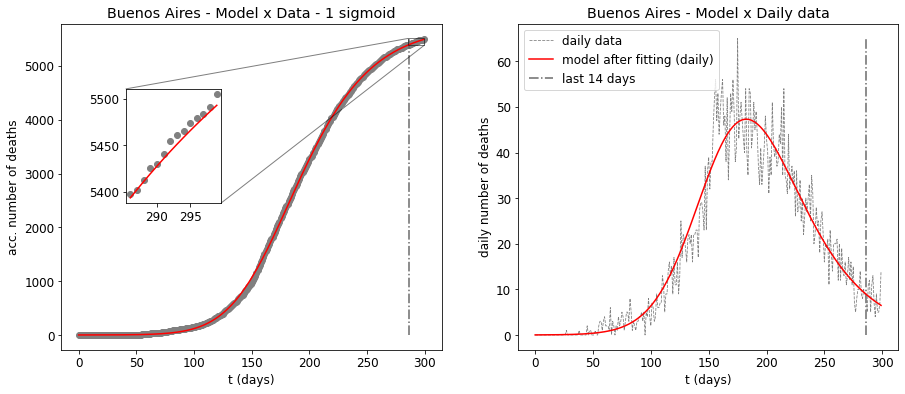

========= Wave nr 2 =========
From 0 to  386
Step 1
     fun: 552.2207484884266
     jac: array([4.57763672e-05, 7.85827637e-04, 2.97546387e-04, 0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 108
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1.08834434e+03, 3.57425786e+02, 1.58262309e+01, 1.00000000e+00])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 537.4331770992025
     jac: array([ 7.62939453e-05, -1.65557861e-03, -5.87463379e-04,  1.96380615e-02])
 message: 'Optimization terminated successfully'
    nfev: 137
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([1.32649031e+03, 3.58632359e+02, 2.59132876e+01, 3.42738808e-01])


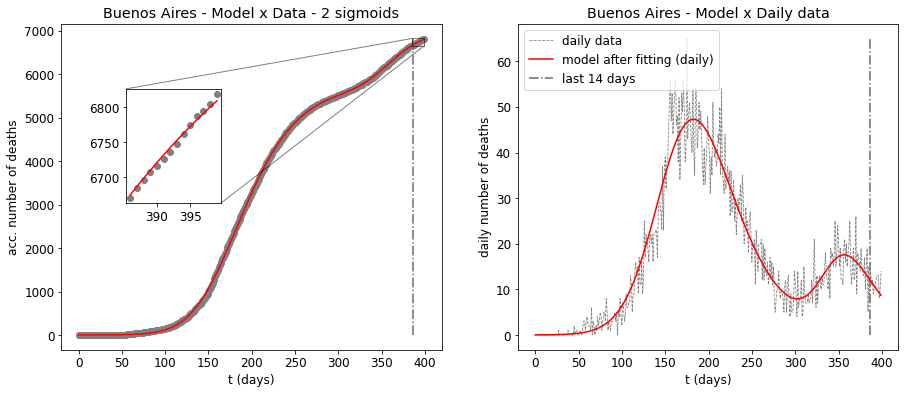

========= Wave nr 3 =========
From 0 to  506
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1485.9598574067377
     jac: array([ 0.00024414, -0.00265503, -0.00427246,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 159
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([3.57198072e+03, 4.62927171e+02, 1.65495077e+01, 1.00000000e+00])
Step 2
     fun: 551.7094029109014
     jac: array([ 4.57763672e-05, -3.28826904e-03, -3.81469727e-03,  5.10865829e+02])
 message: 'Optimization terminated successfully'
    nfev: 106
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([4.25387871e+03, 4.59573430e+02, 3.05001953e+01, 1.00000000e-01])


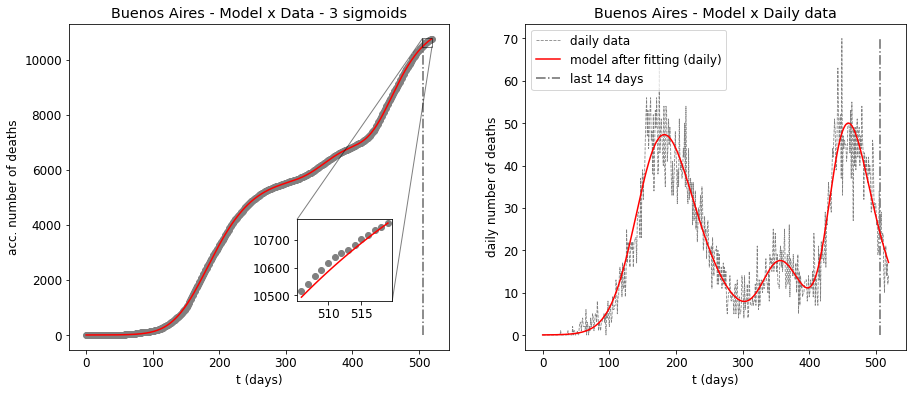

<Figure size 432x288 with 0 Axes>

In [5]:
n_weeks_pred = 2
n_sig = 1
sig_params = []

for i in range(len(x_nw)):
    x_nw[i]
    n_days = x_nw[i]- 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # due to filtering delay
    n_days = x_nw[i]

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    # Plotting Model vs Data

    fig, axs = plt.subplots(1, 2, figsize=[15,6])
    #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    axs[0].set_title(f'{city_name} - Model x Data - {n_sig} sigmoid{s}')
    axs[0].scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
    axs[0].vlines(n_days - 7*n_weeks_pred, 0, max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
    axs[0].plot(y_m, label='Model after fitting', c='r')
    axs[0].set_xlabel('t (days)')
    axs[0].set_ylabel('acc. number of deaths')
    X_detail = t[n_days - 7*n_weeks_pred: n_days]
    Y_detail = y_m[n_days - 7*n_weeks_pred: n_days]
    # detail prediction
    if(n_sig < 3):
        sub_axes = axs[0].inset_axes([.17, .45, .25, .35]) 
    else:
        sub_axes = axs[0].inset_axes([.6, .15, .25, .25]) 
    sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    sub_axes.plot(X_detail, Y_detail, c = 'r') 
    #sub_axes.set_xticks(X_detail[0::3])
    axs[0].indicate_inset_zoom(sub_axes, edgecolor="black")    
    #plt.savefig(f'output/Acc_{city_name}_{n_sig}_sig', facecolor='white', dpi=100)


    # Plotting Daily Data

    axs[1].set_title(f'{city_name} - Model x Daily data')
    axs[1].plot(daily_data[:n_days], label="daily data", c='gray', lw=0.8, linestyle='dashed')
    axs[1].plot(y_m_daily, label='model after fitting (daily)', c='r')
    axs[1].vlines(n_days - 7*n_weeks_pred, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
    axs[1].set_xlabel('t (days)')
    axs[1].set_ylabel('daily number of deaths')
    axs[1].legend(loc=2) # upper left
    # plt.savefig(f'output/Daily_{city_name}_{n_sig}_wave', facecolor='white', dpi=100)
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

plt.tight_layout()
#plt.savefig(f'output/Daily_{city_name}_2w_pred', facecolor='white', dpi=100)
plt.show()


### Predictions - Daily - CLAIB Figures

========= Wave nr 1 =========
From 0 to  286
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 3360.566373137142
     jac: array([-0.00024414, -0.0007019 ,  0.00286865,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 144
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([5.43700999e+03, 1.88800602e+02, 2.72005021e+01, 1.00000000e+00])
Step 2
     fun: 719.2443620288894
     jac: array([ 9.91821289e-05, -3.98254395e-03, -1.50299072e-03,  5.10787964e-02])
 message: 'Optimization terminated successfully'
    nfev: 91
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([5.74499681e+03, 1.82457928e+02, 3.76515170e+01, 3.83543700e-01])
========= Wave nr 2 =========
From 0 to  386
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 552.2207484884266
     jac: array([4.57763672e-05, 7.85827637e-04, 2.97546387e-04, 0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 108
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1.08834434e+03, 3.57425786e+02, 1.58262309e+01, 1.00000000e+00])
Step 2
     fun: 537.4331770992025
     jac: array([ 7.62939453e-05, -1.65557861e-03, -5.87463379e-04,  1.96380615e-02])
 message: 'Optimization terminated successfully'
    nfev: 137
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([1.32649031e+03, 3.58632359e+02, 2.59132876e+01, 3.42738808e-01])
========= Wave nr 3 =========
From 0 to  506
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1485.9598574067377
     jac: array([ 0.00024414, -0.00265503, -0.00427246,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 159
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([3.57198072e+03, 4.62927171e+02, 1.65495077e+01, 1.00000000e+00])
Step 2
     fun: 551.7094029109014
     jac: array([ 4.57763672e-05, -3.28826904e-03, -3.81469727e-03,  5.10865829e+02])
 message: 'Optimization terminated successfully'
    nfev: 106
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([4.25387871e+03, 4.59573430e+02, 3.05001953e+01, 1.00000000e-01])


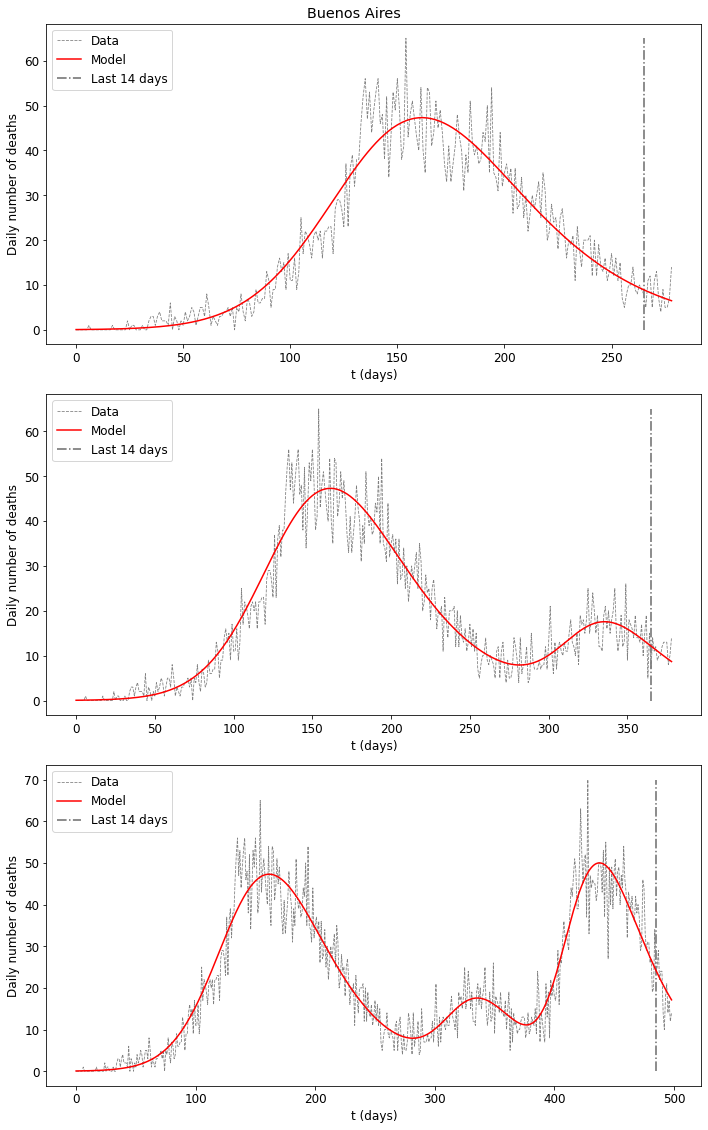

In [6]:
# Predictions for the first three waves
n_weeks_pred = 2
n_sig = 1
sig_params = []

fig, axs = plt.subplots(3, 1, figsize=(10,16))
#fig.suptitle(f'{city_name} - Model x Daily number of deaths')
fig.suptitle(f'{city_name}')
for i in range(len(x_nw)):
    x_nw[i]
    n_days = x_nw[i]- 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # due to filtering delay
    n_days = x_nw[i]

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    if (city_name == 'Buenos Aires'):
        shift_val = 21 # Buenos Aires
    if (city_name == 'Mendoza'):
        shift_val = 7 # Mendoza
    if (city_name == 'Rosario'):
        shift_val = 11 # Rosario
    if (city_name == 'Córdoba'):
        shift_val = 8 # Córdoba

    axs[i].plot(daily_data[shift_val:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[i].plot(y_m_daily[shift_val:], label='Model', c='r')
    axs[i].vlines(n_days - 7*n_weeks_pred - shift_val, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[i].set_xlabel('t (days)')
    axs[i].set_ylabel('Daily number of deaths')
    axs[i].legend(loc=2) # upper left

    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

plt.tight_layout()
plt.savefig(f'CLAIB/{city_name}', facecolor='white', dpi=100)
plt.show()